# Colony forming units (cfu) of mold versus air particulate measurements.

Two things I want to explore: 
* Is there a **particle count** difference between locations with **CFU** measurements above below 10?
* Are particulate counts an indicator of CFU counts?

In [1]:
#importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Explore the data relationships of all your features and understand how the
features compare to the response variable.

● Build data profiles and tables

○ Inferential statistics

● Explore data relationships

○ Data visualization

● Feature Selection and Engineering


### Loading data and building profiles

In [2]:
file = 'data\combined_VAS.csv'
df = pd.read_csv(file,index_col=0,parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Traffic'] = df['Traffic'].astype('category')
df['Weather'] = df['Weather'].astype('category')
df['cfu'] = pd.to_numeric(df['cfu'])
df.reset_index()
df.dtypes

Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Traffic                         category
Weather                         category
cfu                              float64
Source                            object
dtype: object

#### CFU 0 values are genuine 0s. CFU 34 values are spiked values as the true value could be > 34

In [3]:
#the values at 34 actually represent 34 and above. during analysis counting stopped at 34
#for this reason I will take out the 34 values as they may not be accurate.
#Additionally, 44 samples are outdoors.
#particulates data
dfvc = df['location'][df['cfu']==34].value_counts()
df = df[df['cfu']<34]

print(dfvc)

ED Lot              32
OGT4-C4             13
MBH Shuttle Stop    12
OGT3-C5              9
Name: location, dtype: int64


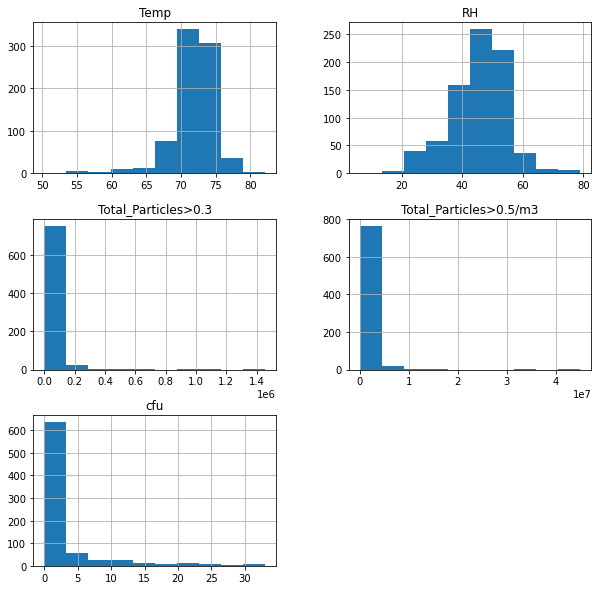

In [4]:
#several non-normal plots
hist = df.hist(bins=10, figsize=(10,10))

#### Adding a threshold value of 10.

In [5]:
#if i'm doing this, should I still consider the particulate data from CFU values of 34?
df['threshold'] = np.where(df['cfu'] < 10, 'under','over')

#### Seperating the data to only look at indoor values.

In [6]:
outside = 'MBH Shuttle Stop','ED Lot'
df['sample_type'] = np.where(df['location'] == outside, 'outdoor','indoor')
df_indoor = df[df['sample_type']=='indoor']

df_indoor.sample(6)

,Date,location,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,Traffic,Weather,cfu,Source,threshold,sample_type
778,2017-05-24,HO-C6835,74.4,42.0,7351.0,373675.0,Low,Overcast,1.0,MB,under,indoor
1565,2016-02-26,GT1-C4,70.8,46.7,2034.0,69868.0,None,Scattered Clouds,1.0,MB,under,indoor
1087,2016-11-21,GT1-C3,68.5,53.6,9232.0,321824.0,None,Scattered Clouds,1.0,MB,under,indoor
1913,2015-07-30,HO-C6827,73.6,50.5,2894.0,123078.0,High,NaN,1.0,MB,under,indoor
1614,2016-01-25,GT2-C3,72.8,44.0,43148.0,775795.0,None,Mostly Cloudy,1.0,MB,under,indoor
460,2018-05-31,L26,68.7,51.0,7876.0,217668.0,Low,Partly Cloudy,1.0,ML,under,indoor


### transforming the particulate data to normal

In [7]:
# particle count numbers are so large that I will scale them down
df_indoor['log03'] = np.log(df_indoor['Total_Particles>0.3'])
df_indoor['log05m3'] = np.log(df_indoor['Total_Particles>0.5/m3'])

logdf = df_indoor[['log03','log05m3','cfu','Source','threshold','location']]
logdf.shape

(793, 6)

#### now the CFU

In [8]:
#lets see if cfu can be normalized
z = np.asarray(logdf['cfu'])
z1 = np.asarray(df_indoor['Total_Particles>0.3'])
z2 = np.asarray(df_indoor['Total_Particles>0.5/m3'])

logdf['zcfu'] = (z - z.mean())/ z.std()
logdf['sqrtcfu'] = np.sqrt(z)
logdf['cbrtcfu'] = np.cbrt(z)
logdf['logcfu'] = np.log((1 + z)/2)
logdf['minmaxcfu'] = (z - z.min()) / (z.max() - z.min())
                
logdf['minmax03'] = (z1 - z1.min()) / (z1.max() - z1.min())
logdf['minmax05m3'] = (z2 - z2.min()) / (z2.max() - z2.min())

<ipython-input-8-b22bf509651d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logdf['zcfu'] = (z - z.mean())/ z.std()
<ipython-input-8-b22bf509651d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logdf['sqrtcfu'] = np.sqrt(z)
<ipython-input-8-b22bf509651d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

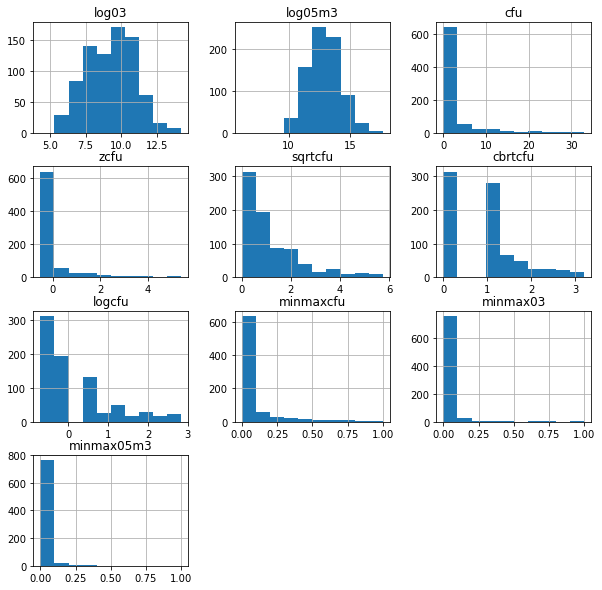

In [9]:
hist = logdf.hist(bins=10, figsize=(10,10))

okay CFU normalization not required.

## Now looking at over and under the 10 CFU threshold

In [10]:
dfT = logdf[['log03','log05m3','threshold']]
binsize = [10,11,12,13,14,15,16,17,18,19,20]

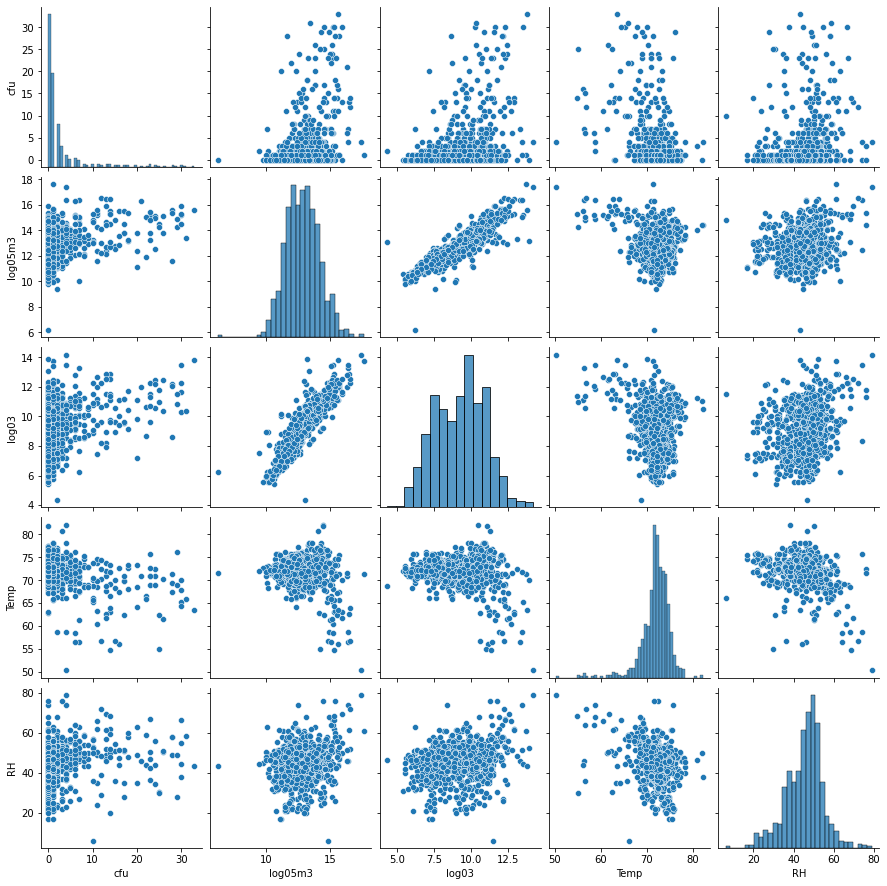

In [11]:
sns.pairplot(df_indoor[['cfu','log05m3','log03','Temp','RH']])

Temp and RH don't seem relevant

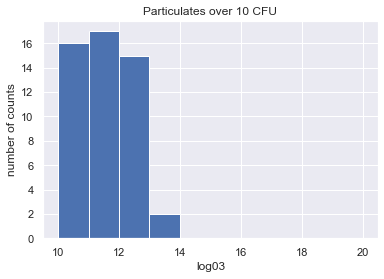

In [12]:
sns.set()
_ = plt.hist(logdf['log03'][dfT['threshold']=='over'],bins=binsize)
_ = plt.xlabel('log03')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates over 10 CFU')
plt.show()

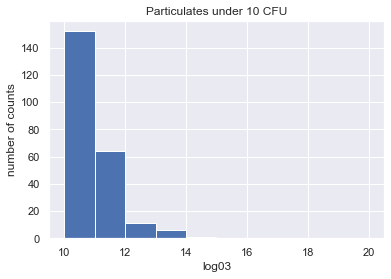

In [13]:
sns.set()
_ = plt.hist(logdf['log03'][dfT['threshold']=='under'],bins=binsize)
_ = plt.xlabel('log03')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates under 10 CFU')
plt.show()

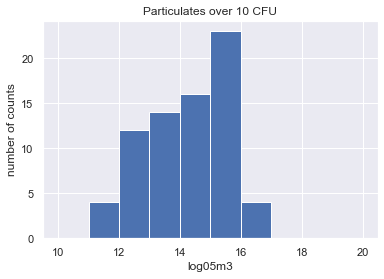

In [14]:
sns.set()
_ = plt.hist(logdf['log05m3'][dfT['threshold']=='over'],bins=binsize)
_ = plt.xlabel('log05m3')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates over 10 CFU')
plt.show()

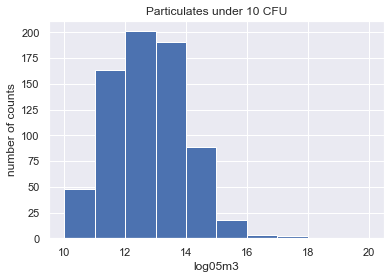

In [15]:
sns.set()
_ = plt.hist(logdf['log05m3'][dfT['threshold']=='under'],bins=binsize)
_ = plt.xlabel('log05m3')
_ = plt.ylabel('number of counts')
_ = plt.title('Particulates under 10 CFU')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


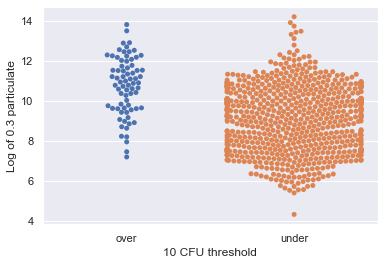

In [16]:
sns.set()
_ = sns.swarmplot(x='threshold', y='log03', data=logdf)
_ = plt.xlabel('10 CFU threshold')
_ = plt.ylabel('Log of 0.3 particulate')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


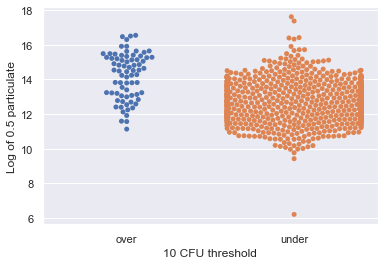

In [17]:
sns.set()
_ = sns.swarmplot(x='threshold', y='log05m3', data=logdf)
_ = plt.xlabel('10 CFU threshold')
_ = plt.ylabel('Log of 0.5 particulate')
plt.show()

<AxesSubplot:xlabel='threshold', ylabel='log03'>

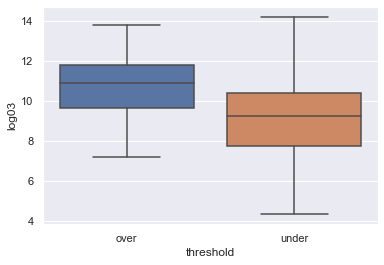

In [18]:
#not many outliers
sns.boxplot(x='threshold',y='log03',data=logdf)

<AxesSubplot:xlabel='threshold', ylabel='log05m3'>

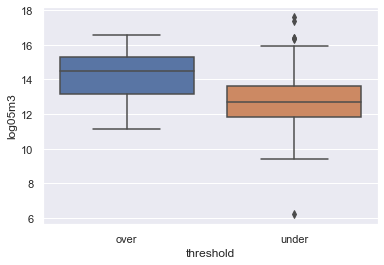

In [19]:
#see a few outliers. should I remove?
sns.boxplot(x='threshold',y='log05m3',data=logdf)

In [20]:
z = np.abs(stats.zscore(logdf['log05m3']))
print(np.where(z > 3))

(array([  3,  40, 589], dtype=int64),)


In [21]:
logdf.groupby('threshold').describe()

log03                                                      \
           count       mean       std       min       25%        50%   
threshold                                                              
over        73.0  10.746153  1.447362  7.199678  9.638675  10.896369   
under      720.0   9.093039  1.640065  4.336100  7.730722   9.223701   

                                log05m3             ...  minmax03            \
                 75%        max   count       mean  ...       75%       max   
threshold                                           ...                       
over       11.767730  13.799796    73.0  14.216956  ...  0.088671  0.676895   
under      10.376351  14.190010   720.0  12.728745  ...  0.022016  1.000000   

          minmax05m3                                                    \
               count      mean       std       min       25%       50%   
threshold                                                                
over            73.0  0.066744  0.075798  0.001507  0.011210  0.044797   
under          720.0  0.017675  0.053415  0.000000  0.003118  0.007432   

                               
                75%       max  
threshold                      
over       0.095489  0.342102  
under      0.017960  1.000000  

[2 rows x 80 columns]

In [22]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

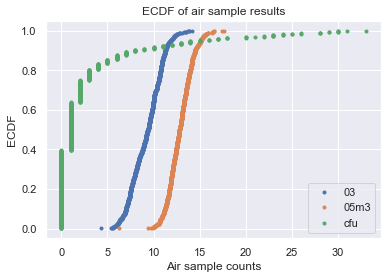

In [23]:
x_03, y_03 = ecdf(logdf['log03'])
x_05, y_05 = ecdf(logdf['log05m3'])
x_cfu, y_cfu = ecdf(logdf['cfu'])

plt.plot(x_03, y_03,marker='.',linestyle='none')
plt.plot(x_05, y_05,marker='.',linestyle='none')
plt.plot(x_cfu, y_cfu,marker='.',linestyle='none')

_ = plt.xlabel('Air sample counts')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF of air sample results')
_ = plt.legend(['03', '05m3', 'cfu'])
plt.show()

#### As expected, the particulate measurements are similar. The CFU value is clearly a different shape

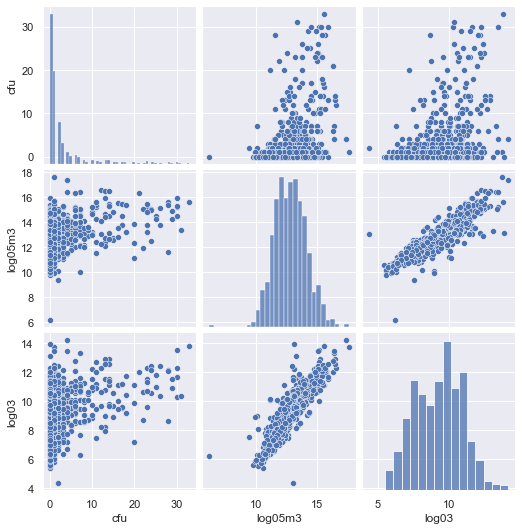

In [24]:
sns.pairplot(df_indoor[['cfu','log05m3','log03']])

In [25]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient
r = pearson_r(logdf['cfu'],logdf['log03'])

# Print the result
print(r)

0.3384292058545213


In [26]:
r = pearson_r(logdf['cfu'],logdf['log05m3'])

print(r)

0.3717790354337135


In [27]:
pearson_r(logdf['log03'],logdf['log05m3'])

0.8838002041472862

### Is there a difference in particulate counts above and below 10cfu? Not likely as the means are so close.

In [28]:
logdf['Permutation1'] = np.random.permutation(logdf['log05m3'])

# Call the describe() method on our permutation grouped by 'platform'. 
logdf.groupby('threshold')['Permutation1'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,73.0,13.129789,1.433558,10.173515,12.135629,13.063619,14.024449,16.506418
under,720.0,12.838971,1.303770,6.204558,11.895561,12.768571,13.719422,17.623260


In [29]:
# Lets compare with the previous analytical summary:
logdf.groupby('threshold')['log05m3'].describe()

,count,mean,std,min,25%,50%,75%,max
threshold,,,,,,,,
over,73.0,14.216956,1.333273,11.132763,13.133258,14.517890,15.274618,16.550635
under,720.0,12.728745,1.237430,6.204558,11.856219,12.722704,13.604224,17.623260
